### Texture Synthesis Using Convolutional Neural Networks (Gatys et al.)
(Source: https://arxiv.org/abs/1505.07376)

Following the implementation in caffe at https://github.com/leongatys/DeepTextures/blob/master/Example.ipynb

Likely a good start for using pyTorch at https://github.com/honzukka/texture-synthesis-pytorch

In [1]:
%matplotlib inline

import os
import glob
import sys

import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image


base_dir = os.getcwd()
sys.path.append(base_dir)
sys.path.append(os.path.join(base_dir, 'texture_synthesis_pytorch'))
im_dir = os.path.join(base_dir, 'images/')

target_image_name = 'unity_cube.jpg'

import utilities
import model
import optimize

imagenet_mean = np.array([ 0.48501961,  0.45795686, 0.40760392 ]) # Imagenet Mean (RGB)

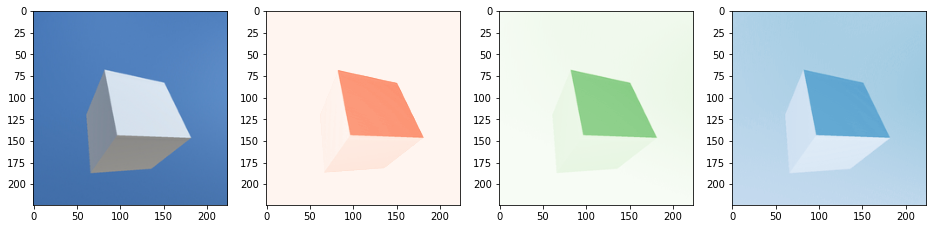

In [2]:
def load_image(file_name, resize_shape=None, vmax=255., mean=imagenet_mean, normalize=True, show_img=False):
    img = Image.open(os.path.join(im_dir, file_name))
    img = np.array(img, dtype=float)
    img /= vmax
    
    if resize_shape is not None:
        img = cv2.resize(img, resize_shape)
    
    if show_img:
        plt.imshow(img)
    
    if normalize:
        img[:,:,0] -= mean[0]
        img[:,:,1] -= mean[1]
        img[:,:,2] -= mean[2]
             
    return img

img = load_image(target_image_name, resize_shape=(224,224))

fig, axs = plt.subplots(1,4, figsize=(16,4))
axs[0].imshow(load_image(target_image_name, normalize=False))
axs[1].imshow(img[:,:,0], vmin=0, vmax=1, cmap='Reds')
axs[2].imshow(img[:,:,1], vmin=0, vmax=1, cmap='Greens')
axs[3].imshow(img[:,:,2], vmin=0, vmax=1, cmap='Blues')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

target_image = utilities.preprocess_image(utilities.load_image(os.path.join(im_dir, target_image_name)))

vgg_model = model.Model(os.path.join(base_dir, 'models', 'VGG19_normalized_avg_pool_pytorch'), device, target_image)
vgg_model.net

Sequential(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace=True)
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3

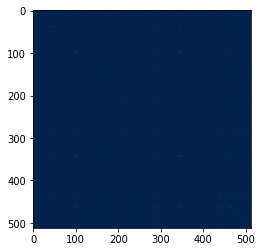

In [4]:
def gram_matrix(activations):
    N = activations.shape[1]
    F = activations.reshape(N, -1)
    M = F.shape[1]
    G = np.dot(F, F.T) / M
    return G

output = vgg_model(target_image).detach().numpy()
g = gram_matrix(output)
plt.imshow(g, cmap='cividis')

In [29]:
N = output.shape[1]
F = output.reshape(N, -1)
M = F.shape[1]

#plt.figure(figsize=(32,32))
#plt.imshow(F, cmap='cividis')

F.shape

(512, 256)

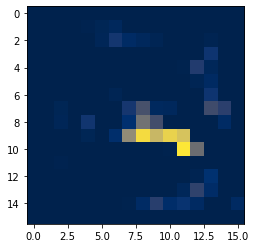

In [5]:
plt.imshow(output[0,1,:,:], cmap='cividis')

In [20]:
vgg_model.net.conv1_1.weight.data.shape

torch.Size([64, 3, 3, 3])

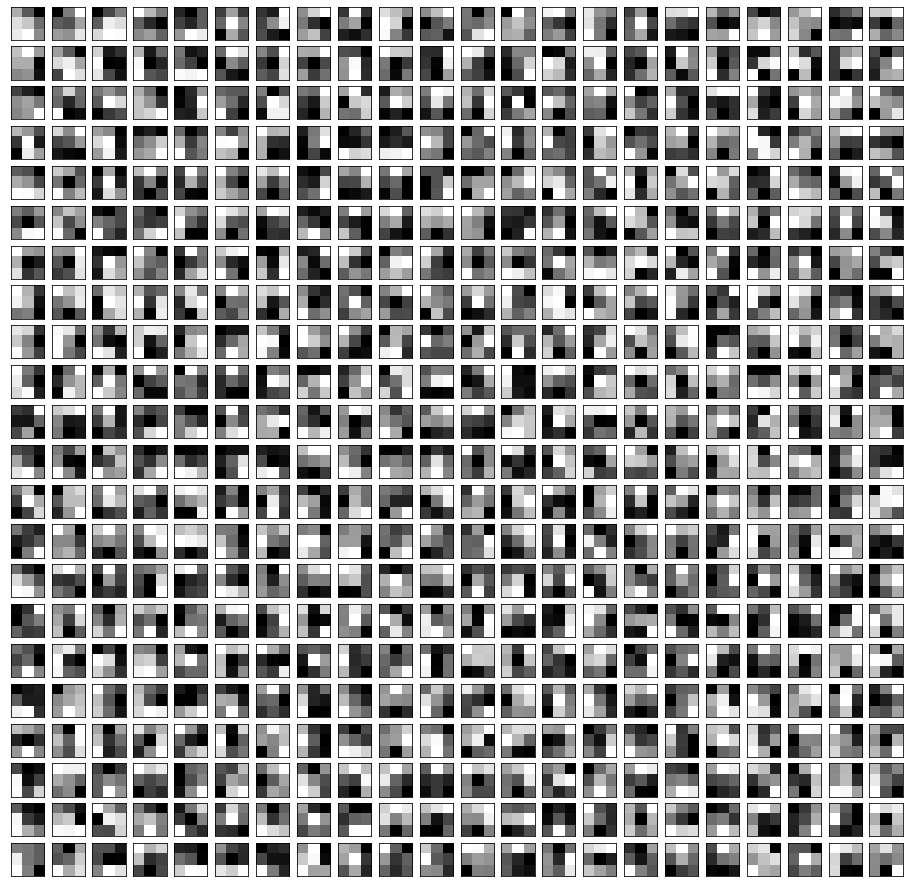

In [28]:
kernels = vgg_model.net.conv4_4.weight.data

#fig, axs = plt.subplots(64, 3, figsize=(16, 16))

n_sqrt = np.sqrt(kernels.shape[0]).astype(int)

channel = 0
#for channel in np.arange(3):
fig, axs = plt.subplots(n_sqrt, n_sqrt, figsize=(16,16))

for xi in np.arange(n_sqrt):
    for yi in np.arange(n_sqrt):
        axs[xi, yi].imshow(kernels[xi*n_sqrt+yi, channel, :, :], cmap='gray')
        axs[xi, yi].xaxis.set_ticklabels([])
        axs[xi, yi].yaxis.set_ticklabels([])
        axs[xi, yi].set_xticks([])
        axs[xi, yi].set_yticks([])

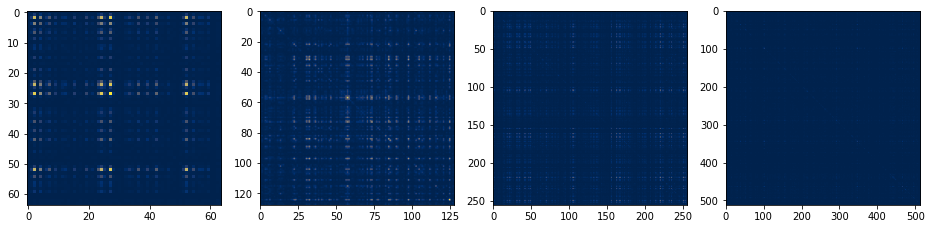

In [5]:
def plot_gram_at(last_layer_index):
    partial_net = torch.nn.Sequential()
    for idx, layer in enumerate(list(vgg_model.net)[0:last_layer_index+1]):
        partial_net.add_module(str(idx), layer)

    vgg_model.gram_loss_hook.clear()
    output = partial_net(target_image)
    return gram_matrix(output.detach().numpy())

fig, axs = plt.subplots(1, 4, figsize=(16,4))

axs[0].imshow(plot_gram_at(4), cmap='cividis')
axs[1].imshow(plot_gram_at(9), cmap='cividis')
axs[2].imshow(plot_gram_at(18), cmap='cividis')
axs[3].imshow(plot_gram_at(27), cmap='cividis')

In [34]:
import utilities
import model
import optimize

import importlib
importlib.reload(utilities)
importlib.reload(model)
importlib.reload(optimize)


import collections.abc as container_abcs

from argparse import Namespace
args = Namespace(**{
    'checkpoint_every': 1,
    'n_steps': 25,
    'max_iter': 5,
    'lr': 1.0
})

optimizer = optimize.Optimizer(vgg_model, args)
result = optimizer.optimize()

final_image = utilities.postprocess_image(result, utilities.load_image(os.path.join(im_dir, target_image_name)))
final_image.save('output.png')


KeyboardInterrupt: 

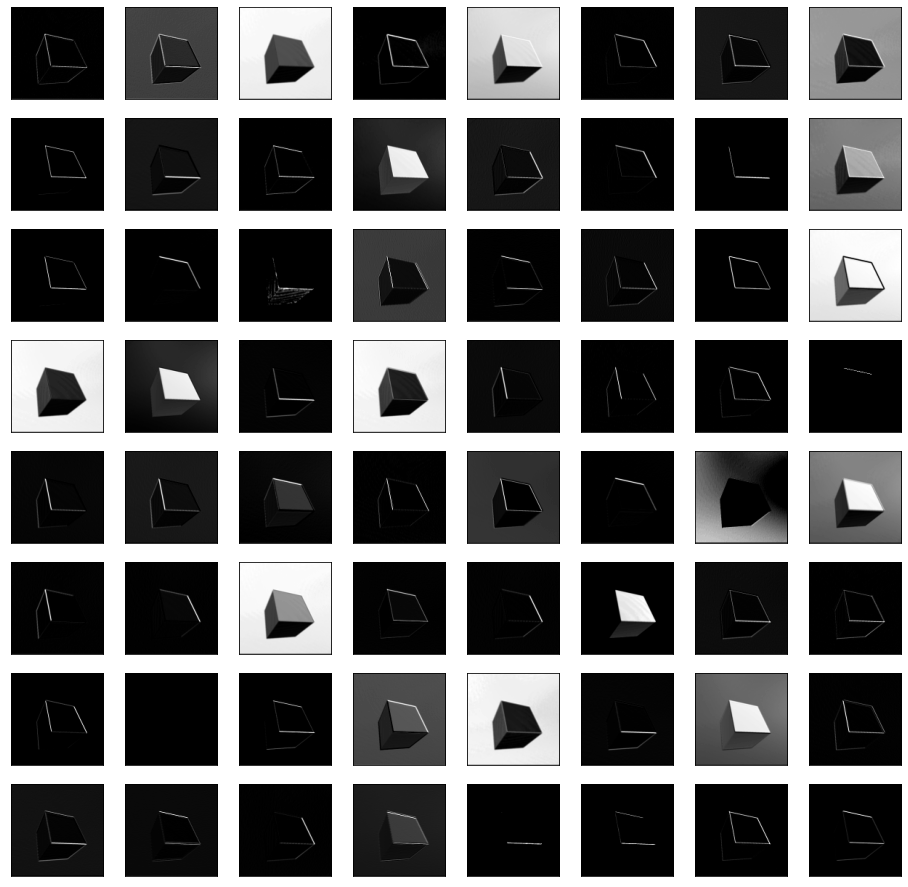

In [7]:
def extract_output_at(last_layer_index):
    partial_net = torch.nn.Sequential()
    for idx, layer in enumerate(list(vgg_model.net)[0:last_layer_index+1]):
        partial_net.add_module(str(idx), layer)

    vgg_model.gram_loss_hook.clear()
    output = partial_net(target_image)
    return output.detach().numpy()

pool = extract_output_at(4)
#pool = extract_output_at(9)
#pool = extract_output_at(18)
#pool = extract_output_at(27)
pool = pool.reshape(pool.shape[1:])

num_filter_sqrt = int(np.sqrt(pool.shape[0]))

fig, axs = plt.subplots(num_filter_sqrt, num_filter_sqrt, figsize=(16,16))

for x in range(len(axs[0,:])):
    for y in range(len(axs[x,:])):
        filter_num = x * num_filter_sqrt + y
        
        axs[x,y].imshow(pool[filter_num,:,:], cmap='gray')
        axs[x,y].xaxis.set_ticklabels([])
        axs[x,y].yaxis.set_ticklabels([])
        axs[x,y].set_xticks([])
        axs[x,y].set_yticks([])

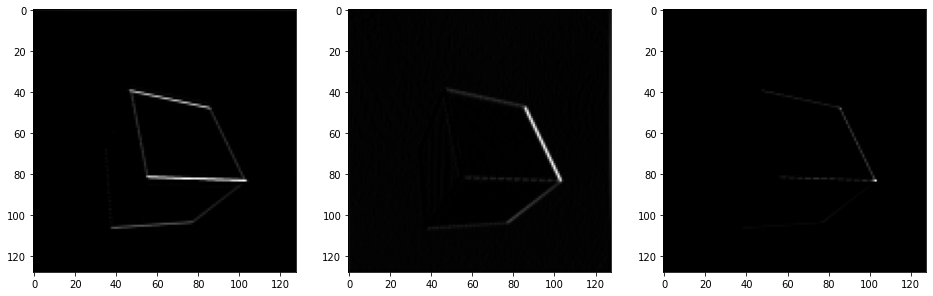

In [38]:
#i,j = np.random.choice(np.arange(pool.shape[0]), 2, replace=False)
i,j = 50, 44

fm_i = pool[i,:,:]
fm_j = pool[j,:,:]
corr = np.multiply(fm_i, fm_j)
"""

fm_i = np.random.randn(4).reshape((2,2))
fm_j = np.random.randn(4).reshape((2,2))
corr = np.multiply(fm_i, fm_j)

"""
fig, axs = plt.subplots(1, 3, figsize=(16,16))

axs[0].imshow(fm_i, cmap='gray')
axs[1].imshow(fm_j, cmap='gray')
axs[2].imshow(corr, cmap='gray')